In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization, Conv2D, UpSampling2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

In [2]:
# Channel last
def get_unet():
    concat_axis = 3 # 3 o 1
#    concat_axis = 1 
    #inputs = layers.Input(shape = (80, 120, 3))
    inputs = layers.Input(shape = (128, 144, 3))
    
    #encoder
    bn0 = BatchNormalization(axis=3)(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_1')(bn0)
    bn1 = BatchNormalization(axis=3)(conv1)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(bn1)
    bn2 = BatchNormalization(axis=3)(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(bn2)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    bn3 = BatchNormalization(axis=3)(conv2)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(bn3)
    bn4 = BatchNormalization(axis=3)(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(bn4)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    bn5 = BatchNormalization(axis=3)(conv3)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(bn5)
    bn6 = BatchNormalization(axis=3)(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(bn6)

    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    bn7 = BatchNormalization(axis=3)(conv4)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(bn7)
    bn8 = BatchNormalization(axis=3)(conv4)
    #pool4 = layers.MaxPooling2D(pool_size=(2, 3))(bn8)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(bn8)
    
    conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    bn9 = BatchNormalization(axis=3)(conv5)
    conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(bn9)
    bn10 = BatchNormalization(axis=3)(conv5)

    ##decoder
    #up_conv5 = layers.UpSampling2D(size=(2, 3))(bn10)
    up_conv5 = layers.UpSampling2D(size=(2, 2))(bn10)
    up6 = layers.concatenate([up_conv5, conv4], axis=concat_axis)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    bn11 = BatchNormalization(axis=3)(conv6)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(bn11)
    bn12 = BatchNormalization(axis=3)(conv6)

    up_conv6 = layers.UpSampling2D(size=(2, 2))(bn12)
    up7 = layers.concatenate([up_conv6, conv3], axis=concat_axis)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    bn13 = BatchNormalization(axis=3)(conv7)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(bn13)
    bn14 = BatchNormalization(axis=3)(conv7)

    up_conv7 = layers.UpSampling2D(size=(2, 2))(bn14)
    up8 = layers.concatenate([up_conv7, conv2], axis=concat_axis)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    bn15 = BatchNormalization(axis=3)(conv8)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(bn15)
    bn16 = BatchNormalization(axis=3)(conv8)

    up_conv8 = layers.UpSampling2D(size=(2, 2))(bn16)
    up9 = layers.concatenate([up_conv8, conv1], axis=concat_axis)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    bn17 = BatchNormalization(axis=3)(conv9)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(bn17)
    bn18 = BatchNormalization(axis=3)(conv9)

    conv10 = layers.Conv2D(1, (1, 1))(bn18)
    #bn19 = BatchNormalization(axis=1)(conv10)

    model = models.Model(inputs=inputs, outputs=conv10)

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mae', optimizer=sgd, metrics=['mse','acc'])
    #model.compile(loss='mae', optimizer=Adam(lr=0.01), metrics=['mse'])
    print(model.summary())

    return model

In [3]:
model = get_unet()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 144, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 144, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 128, 144, 32) 896         batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 144, 32) 128         conv1_1[0][0]                    
______________________________________________________________________________________________

In [4]:
'''
Obtenemos lluvias en tiempo t + 1
Cargar en caso de no tener dividido el dataset en train, test y validación.
'''

Y = np.load("/opt/datos/dataset/gfs/Y.npy")
Y_next = np.zeros((19287, 137, 157))

for i in range(Y_next.shape[0]):
    Y_next[i] = Y[i+1]

In [5]:
Y = None

In [6]:
# carga dataset rain and wind

#X = np.load("/opt/datos/dataset/gfs/wind/X_rain700.npy")
X = np.load("/opt/datos/dataset/gfs/wind/X_rain850.npy")

X_train = X[:13502, :, :, :]
X_val   = X[13502:16395, :, :, :]

print(X_train.shape)
print(X_val.shape)

X = None

Y_train = Y_next[:13502, :, :]
Y_val   = Y_next[13502:16395, :, :]

Y_next = None

print(Y_train.shape)
print(Y_val.shape)

(13502, 3, 137, 157)
(2893, 3, 137, 157)
(13502, 137, 157)
(2893, 137, 157)


### Shuffle

In [4]:
# 700 mb
#X_train = np.load("/opt/datos/dataset/gfs/wind/shuffle/X_train700.npy")
#X_val   = np.load("/opt/datos/dataset/gfs/wind/shuffle/X_val700.npy")

#850 mb
X_train = np.load("/opt/datos/dataset/gfs/wind/shuffle/X_train850.npy")
X_val   = np.load("/opt/datos/dataset/gfs/wind/shuffle/X_val850.npy")

Y_train = np.load("/opt/datos/dataset/gfs/wind/shuffle/Y_train700.npy")
Y_val   = np.load("/opt/datos/dataset/gfs/wind/shuffle/Y_val700.npy")

In [5]:
# Recorte para obtener 128x144
X_train = X_train[:, :, 0:128, 0:144]
X_val = X_val[:, :, 0:128, 0:144]
print(X_train.shape)
print(X_val.shape)

Y_train = Y_train[:, 0:128, 0:144]
Y_val = Y_val[:, 0:128, 0:144]
print(Y_train.shape)
print(Y_val.shape)

(13502, 3, 128, 144)
(2893, 3, 128, 144)
(13502, 128, 144)
(2893, 128, 144)


In [6]:
Y_train = np.expand_dims(Y_train, axis=1)
Y_val = np.expand_dims(Y_val, axis=1)

print(Y_train.shape)
print(Y_val.shape)

(13502, 1, 128, 144)
(2893, 1, 128, 144)


In [7]:
# Muevo el eje RGB al ultimo
X_train = np.moveaxis(X_train, 1, 3)
X_val = np.moveaxis(X_val, 1, 3)
print("X_train: %s" %str(X_train.shape))
print("X_val: %s" %str(X_val.shape))

Y_train = np.moveaxis(Y_train, 1, 3)
Y_val = np.moveaxis(Y_val, 1, 3)
print("Y_train: %s" %str(Y_train.shape))
print("Y_val: %s" %str(Y_val.shape))

X_train: (13502, 128, 144, 3)
X_val: (2893, 128, 144, 3)
Y_train: (13502, 128, 144, 1)
Y_val: (2893, 128, 144, 1)


In [8]:
start = time.time()
history = model.fit(X_train, Y_train, epochs=100, verbose=1, validation_data=(X_val, Y_val))
finish = time.time()
time = finish - start

Epoch 1/100
422/422 [==============================] - 319s 590ms/step - loss: 0.4198 - mse: 2.1479 - acc: 0.7404 - val_loss: 0.3425 - val_mse: 1.8112 - val_acc: 0.7521
Epoch 2/100
422/422 [==============================] - 168s 398ms/step - loss: 0.3245 - mse: 1.7637 - acc: 0.7533 - val_loss: 0.3074 - val_mse: 1.6813 - val_acc: 0.7572
Epoch 3/100
422/422 [==============================] - 168s 398ms/step - loss: 0.3146 - mse: 1.7170 - acc: 0.7573 - val_loss: 0.2977 - val_mse: 1.6232 - val_acc: 0.7570
Epoch 4/100
422/422 [==============================] - 168s 398ms/step - loss: 0.3068 - mse: 1.6634 - acc: 0.7585 - val_loss: 0.3021 - val_mse: 1.7096 - val_acc: 0.7577
Epoch 5/100
422/422 [==============================] - 168s 398ms/step - loss: 0.3008 - mse: 1.6081 - acc: 0.7578 - val_loss: 0.2984 - val_mse: 1.5969 - val_acc: 0.7570
Epoch 6/100
422/422 [==============================] - 168s 398ms/step - loss: 0.2988 - mse: 1.5802 - acc: 0.7581 - val_loss: 0.2944 - val_mse: 1.5935 - va

422/422 [==============================] - 168s 398ms/step - loss: 0.2346 - mse: 0.9513 - acc: 0.7659 - val_loss: 0.2848 - val_mse: 1.4712 - val_acc: 0.7581
Epoch 50/100
422/422 [==============================] - 168s 398ms/step - loss: 0.2335 - mse: 0.9330 - acc: 0.7633 - val_loss: 0.3046 - val_mse: 1.5580 - val_acc: 0.7564
Epoch 51/100
422/422 [==============================] - 168s 398ms/step - loss: 0.2329 - mse: 0.9294 - acc: 0.7634 - val_loss: 0.2825 - val_mse: 1.4642 - val_acc: 0.7570
Epoch 52/100
422/422 [==============================] - 168s 398ms/step - loss: 0.2321 - mse: 0.9187 - acc: 0.7640 - val_loss: 0.2830 - val_mse: 1.4532 - val_acc: 0.7568
Epoch 53/100
422/422 [==============================] - 168s 398ms/step - loss: 0.2292 - mse: 0.8970 - acc: 0.7620 - val_loss: 0.2891 - val_mse: 1.4478 - val_acc: 0.7564
Epoch 54/100
422/422 [==============================] - 168s 398ms/step - loss: 0.2295 - mse: 0.9020 - acc: 0.7633 - val_loss: 0.2883 - val_mse: 1.4561 - val_acc: 

422/422 [==============================] - 168s 398ms/step - loss: 0.2057 - mse: 0.7122 - acc: 0.7644 - val_loss: 0.2883 - val_mse: 1.4868 - val_acc: 0.7558
Epoch 98/100
422/422 [==============================] - 168s 398ms/step - loss: 0.2047 - mse: 0.6967 - acc: 0.7665 - val_loss: 0.2916 - val_mse: 1.4787 - val_acc: 0.7559
Epoch 99/100
422/422 [==============================] - 168s 398ms/step - loss: 0.2047 - mse: 0.6985 - acc: 0.7655 - val_loss: 0.2883 - val_mse: 1.4818 - val_acc: 0.7567
Epoch 100/100
422/422 [==============================] - 168s 398ms/step - loss: 0.2025 - mse: 0.6778 - acc: 0.7667 - val_loss: 0.2859 - val_mse: 1.4576 - val_acc: 0.7559


In [11]:
### TIME 20 epoch unet 700mb: 3450.580164909363 seg
### TIME 100 epoch unet 700mb:16884.650401115417
print(time)

16884.650401115417


In [11]:
### TIME 20 epoch unet 850mb: 3470.6787447929382 seg 
### TIME 100 epoch unet 850mb:
print(time)

3470.6787447929382


In [9]:
### TIME 20 epoch unet shuffle 700mb: 3466.810744524002 seg
### TIME 100 epoch unet shuffle 700mb:
print(time)

3466.810744524002


In [9]:
### TIME 20 epoch unet shuffle 850mb: 3476.004170179367 seg
### TIME 100 epoch unet shuffle 850mb: 16952.29919195175
print(time)

16952.29919195175


In [10]:
with open('/opt/datos/entrenamientos/gfs/wind/08/history', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [11]:
history = pickle.load( open( "/opt/datos/entrenamientos/gfs/wind/08/history", "rb" ) )

~ Unet Dataset: wind-rain GFS 2015-2021 ~
val_loss: 0.28591427206993103
loss: 0.20372933149337769


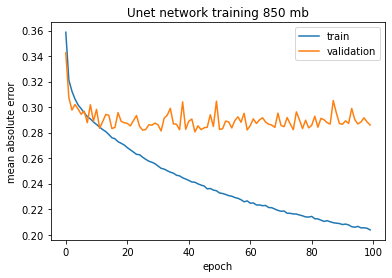

In [12]:
print("~ Unet Dataset: wind-rain GFS 2015-2021 ~")
print(f"val_loss: {history['val_loss'][-1]}")
print(f"loss: {history['loss'][-1]}")
#print(history)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Unet network training 850 mb')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [13]:
model.save('/opt/datos/entrenamientos/gfs/wind/08/model.h5')

## En caso de necesitar guardar datos con shuffle

In [6]:
# Creando dataset con SHUFFLE rain and wind, no es necesario si ya se tiene .npy guardados.

idxs = np.arange(Y_next.shape[0])
np.random.seed(0)
np.random.shuffle(idxs)

### Y
Y_next = Y_next[idxs, :, :]

Y_train = Y_next[:13502, :, :]      # 70%
Y_val   = Y_next[13502:16395, :, :] # 15%
Y_test   = Y_next[16395:, :, :]     # 15%

Y_next = None

print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

### X
#X = np.load("/opt/datos/dataset/gfs/wind/X_rain700.npy")
X = np.load("/opt/datos/dataset/gfs/wind/X_rain850.npy")
X = X[0:19287, :, :, :]

X = X[idxs, :, :, :]

X_train = X[:13502, :, :, :]
X_val   = X[13502:16395, :, :, :]
X_test   = X[16395:, :, :, :]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

X = None

(13502, 3, 137, 157)
(2893, 3, 137, 157)
(2892, 3, 137, 157)


In [7]:
np.save("/opt/datos/dataset/gfs/wind/shuffle/X_train850.npy", X_train)
np.save("/opt/datos/dataset/gfs/wind/shuffle/X_val850.npy", X_val)
np.save("/opt/datos/dataset/gfs/wind/shuffle/X_test850.npy", X_test)